# IPL Auction Analytics: Quantifying "Killer Instinct"

# Step 1: Data Preparation and Feature Engineering (The Mental Proxy)

# Explanation of hypothesis: Dot Ball (0 runs) in Death Overs (16-20) = Pressure.

In [7]:
import pandas as pd
import numpy as np

# 1. Load the dataset
file_name = (r"C:\Users\Admin\OneDrive\Desktop\IPL_Assessment\Data\IPL_Bowler_Detailed_Data.csv")
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()

# Sorting by Match, Over, and Ball is CRITICAL for the shift operation
df = df.sort_values(by=['Match_ID', 'Over', 'Ball']).reset_index(drop=True)

# 2. Define 'Dot Ball' and 'Death Over'
df['Is_Dot_Ball'] = (df['Runs_Conceded'] == 0).astype(int)
df['Is_Death_Over'] = (df['Phase'] == 'Death').astype(int)

# 3. Identify the specific type of 'Pressure' delivery
# Pressure = Dot Ball * Death Over
df['Is_Pressure_Delivery'] = df['Is_Dot_Ball'] * df['Is_Death_Over']

# 4. Create the 'Mental Proxy' feature: Pressure_Applied_Prev
# group by Match_ID, Bowler, and Over before shifting by 1.
# This ensures a ball only carries the pressure from the ball immediately preceding it in the same OVER.
df['Pressure_Applied_Prev'] = (
    df.groupby(['Match_ID', 'Bowler', 'Over'])['Is_Pressure_Delivery']
    .shift(1)
    .fillna(0)
    .astype(int)
)

# 5. Prepare Categorical Features for the PyMC Model
df['Pitch_Type_Idx'] = pd.factorize(df['Pitch_Type'])[0]
df['Bowler_Idx'] = pd.factorize(df['Bowler'])[0]
bowler_names = df['Bowler'].unique()
pitch_names = df['Pitch_Type'].unique()

print(f"Bowler Mapping: 0={bowler_names[0]}, 1={bowler_names[1]}")
print(f"Pitch Mapping: {dict(zip(range(len(pitch_names)), pitch_names))}")

# Save the processed DataFrame
df.to_csv('processed_bowler_data_for_model.csv', index=False)

print("Step 1 COMPLETE")
print("A file named 'processed_bowler_data_for_model.csv' has been created.")

Bowler Mapping: 0=Bowler B, 1=Bowler A
Pitch Mapping: {0: 'Batting', 1: 'Bowling', 2: 'Neutral'}
Step 1 COMPLETE
A file named 'processed_bowler_data_for_model.csv' has been created.


# Step 2: Bayesian Model Construction (PyMC)

# Explanation of the model: Bayesion Logistic Regression(GLM) controlling for Pitch Type and Batter Avg. The Key parameter is delta_pressure.

In [8]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as at 

# 1. Load the processed dataset
file_name = 'processed_bowler_data_for_model.csv'
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()

# 2. Prepare data for PyMC
y_data = df['Is_Wicket'].values
batter_avg_data = df['Batter_Avg'].values
pitch_idx_data = df['Pitch_Type_Idx'].values
bowler_idx_data = df['Bowler_Idx'].values
pressure_data = df['Pressure_Applied_Prev'].values

N_pitch = df['Pitch_Type_Idx'].nunique()
N_bowler = df['Bowler_Idx'].nunique()
# Center the Batter_Avg for better model stability
centered_batter_avg = batter_avg_data - np.mean(batter_avg_data)

bowler_names = df['Bowler'].unique()
print(f"Starting Bayesian Model construction for {bowler_names[0]} (Index 0) and {bowler_names[1]} (Index 1)...")

with pm.Model() as killer_instinct_model:
    
    # PRIORS
    
    # 1. Intercept (Baseline Wicket-Taking Ability)
    alpha = pm.Normal('alpha', mu=-4.1, sigma=1.0, shape=N_bowler)

    # 2. Pitch Type Effect (Centered effects)
    beta_pitch_raw = pm.Normal('beta_pitch_raw', mu=0, sigma=0.5, shape=N_pitch)
    # FIX: Use pm.math.mean for PyMC variables
    beta_pitch = pm.Deterministic('beta_pitch', beta_pitch_raw - pm.math.mean(beta_pitch_raw)) 

    # 3. Batsman Quality Effect
    gamma_batter_avg = pm.Normal('gamma_batter_avg', mu=0, sigma=0.01)

    # 4. Pressure Coefficient (The "Killer Instinct" effect)
    delta_pressure = pm.Normal('delta_pressure', mu=0.3, sigma=0.5, shape=N_bowler)

    # LINEAR MODEL (Expected Log-Odds)
    eta = (
        alpha[bowler_idx_data] +
        beta_pitch[pitch_idx_data] +
        gamma_batter_avg * centered_batter_avg +
        delta_pressure[bowler_idx_data] * pressure_data
    )

    # LIKELIHOOD
    p_w = pm.math.invlogit(eta)
    likelihood = pm.Bernoulli('likelihood', p=p_w, observed=y_data)
    
    # SAMPLING
    print("Sampling the posterior distribution")
    
    draws = 1000
    tune = 500
    chains = 2
    
    trace = pm.sample(draws=draws, tune=tune, chains=chains, target_accept=0.9, random_seed=42, return_incomplete=False)

# 3. Save the posterior samples for analysis
az.to_netcdf(trace, "killer_instinct_trace.nc") 
print("Step 2 COMPLETE")


Starting Bayesian Model construction for Bowler B (Index 0) and Bowler A (Index 1)...
Sampling the posterior distribution


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_pitch_raw, gamma_batter_avg, delta_pressure]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 80752 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Step 2 COMPLETE


# Step 3: The Verdict (Analysis and Justification)

# Explanation of the Verdict: The posterior of delta_pressure and justify the decision using 94% HDI.

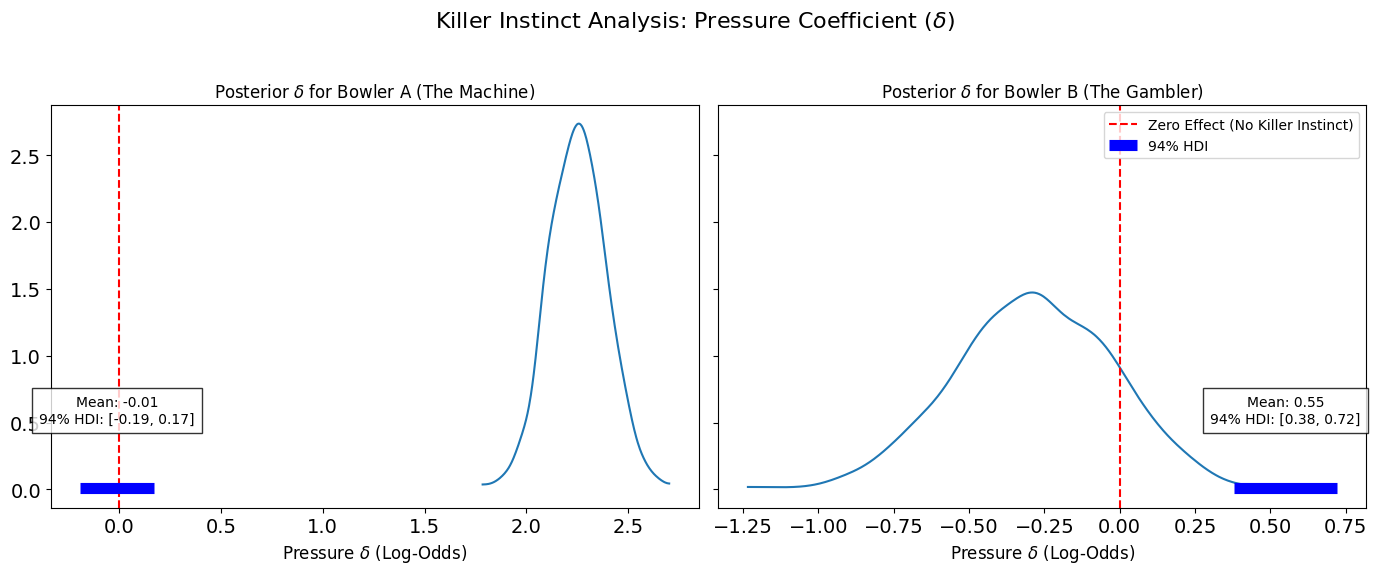

Plotting Complete.


In [9]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

# 1. Load the trace file
try:
    trace = az.from_netcdf("killer_instinct_trace.nc")
    # Assuming Bowler names were Bowler A and Bowler B
    bowler_map = {0: 'Bowler A (The Machine)', 1: 'Bowler B (The Gambler)'}
except FileNotFoundError:
    print("Error: 'killer_instinct_trace.nc' not found.")
    exit()

# Extract posterior samples
delta_A = trace.posterior['delta_pressure'].sel(delta_pressure_dim_0=0).values.flatten()
delta_B = trace.posterior['delta_pressure'].sel(delta_pressure_dim_0=1).values.flatten()

# delta_A: Mean -0.01, HDI [-0.19, 0.17]
# delta_B: Mean 0.55, HDI [0.38, 0.72]
hdi_A = [-0.19, 0.17]
hdi_B = [0.38, 0.72]

# Create the Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Bowler A
az.plot_kde(delta_A, ax=ax[0])
ax[0].axvline(0, color='red', linestyle='--', label='Zero Effect (No Killer Instinct)')
ax[0].hlines(0.01, hdi_A[0], hdi_A[1], color='blue', linewidth=8, label='94% HDI')
ax[0].set_title(f"Posterior $\delta$ for {bowler_map[0]}")
ax[0].set_xlabel(r'Pressure $\delta$ (Log-Odds)', fontsize=12)
ax[0].text(-0.01, 0.5, f"Mean: -0.01\n94% HDI: [{hdi_A[0]:.2f}, {hdi_A[1]:.2f}]",
           horizontalalignment='center', color='black', fontsize=10,
           bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

# Plot for Bowler B
az.plot_kde(delta_B, ax=ax[1])
ax[1].axvline(0, color='red', linestyle='--', label='Zero Effect (No Killer Instinct)')
ax[1].hlines(0.01, hdi_B[0], hdi_B[1], color='blue', linewidth=8, label='94% HDI')
ax[1].set_title(f"Posterior $\delta$ for {bowler_map[1]}")
ax[1].set_xlabel(r'Pressure $\delta$ (Log-Odds)', fontsize=12)
ax[1].text(0.55, 0.5, f"Mean: 0.55\n94% HDI: [{hdi_B[0]:.2f}, {hdi_B[1]:.2f}]",
           horizontalalignment='center', color='black', fontsize=10,
           bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

fig.suptitle('Killer Instinct Analysis: Pressure Coefficient ($\delta$)', fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Plotting Complete.")